In [1]:
import os
import gc
import sys
import time
import math
import json
import spacy
import random
import logging
import argparse
import itertools
import numpy as np
import _pickle as cPickle
import torch
os.chdir("../../src/shared/")
from classes import *
os.chdir("../../data/feature_ELMO/")

In [2]:
logging.info('Loading training and dev data...')
with open('training_data',"rb") as f:
    training_data = cPickle.load(f)
with open("dev_data", 'rb') as f:
    dev_data = cPickle.load(f)
with open("test_data", 'rb') as f:
    test_data = cPickle.load(f)

In [3]:
entity_mentions = []
event_mentions = []
for _, topic in test_data.topics.items():
    docs = topic.docs
    for _, doc in docs.items():
        for _, sent in doc.sentences.items():
            entity_mentions.extend(sent.gold_entity_mentions)
            event_mentions.extend(sent.gold_event_mentions)

In [114]:
entity_d = {}
event_d = {}

for entity in entity_mentions:
    tag = entity.gold_tag
    if tag in entity_d:
        entity_d[tag].append(entity)
    else:
        entity_d[tag] = [entity]

entity_d

{'HUM17642655532934542': [<classes.EntityMention at 0x154f61a60>,
 'LOC17642835073942721': [<classes.EntityMention at 0x154f61ac0>,
 'HUM18520763746825423': [<classes.EntityMention at 0x154f61be0>,
 'HUM17720489125766418': [<classes.EntityMention at 0x15502a2b0>,
 'TIM17720510666890266': [<classes.EntityMention at 0x15502a3d0>,
 'Singleton_HUM_31_36_2ecb': [<classes.EntityMention at 0x1550bae80>],
 'LOC17642819306422986': [<classes.EntityMention at 0x1550bae50>,
 'HUM18264694756319567': [<classes.EntityMention at 0x155193370>,
 'HUM17720479085668575': [<classes.EntityMention at 0x155193430>,
 'TIM17720499285731832': [<classes.EntityMention at 0x155193580>,
 'HUM17642625776844813': [<classes.EntityMention at 0x1552b3670>,
 'HUM17642639895581929': [<classes.EntityMention at 0x1552b3730>,
 'Singleton_HUM_47_36_3ecb': [<classes.EntityMention at 0x1553ab0a0>],
 'Singleton_LOC_42_36_3ecb': [<classes.EntityMention at 0x1553ab070>],
 'Singleton_LOC_50_36_3ecb': [<classes.EntityMention at 0x155

In [115]:
event_d = {}
for event in event_mentions:
    tag = event.gold_tag
    if tag in event_d:
        event_d[tag].append(event)
    else:
        event_d[tag] = [event]

# entity_d = event_d

In [116]:
import itertools
def findsubsets(s, n):
    return list(itertools.combinations(s, n))

cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)


In [117]:
all_mentions = [v for k,v in entity_d.items()]
all_m = []
for mentions in all_mentions:
    for m in mentions:
        all_m.append(m)
all_m = findsubsets(all_m,2)

In [118]:
cd_notcoref = []
wd_notcoref = []
len(all_m)
for subset in all_m:
    if subset[0].gold_tag != subset[1].gold_tag:
        if subset[0].doc_id == subset[1].doc_id:
            wd_notcoref.append(round(cos(subset[0].head_elmo_embeddings, subset[1].head_elmo_embeddings).tolist(),2))
        else:
            cd_notcoref.append(round(cos(subset[0].head_elmo_embeddings, subset[1].head_elmo_embeddings).tolist(),2))
    

In [119]:
len(wd_notcoref)

10959

In [120]:
len(cd_notcoref)

2081516

In [121]:
# for i,v in event_d.items():
#     for event in v:
#         print(event.doc_id)

In [122]:
wd_result = []
cd_result = []
for i,v in entity_d.items():
    if len(v)>1: # singletons
        subsets = findsubsets(v,2)
        for subset in subsets:
            if subset[0].doc_id == subset[1].doc_id:
                wd_result.append(round(cos(subset[0].head_elmo_embeddings, subset[1].head_elmo_embeddings).tolist(),2))
            else:
                cd_result.append(round(cos(subset[0].head_elmo_embeddings, subset[1].head_elmo_embeddings).tolist(),2))

In [123]:
from collections import Counter
wd_result = Counter(wd_result)
cd_result = Counter(cd_result)
wd_notc_result = Counter(wd_notcoref)
cd_notc_result = Counter(cd_notcoref)

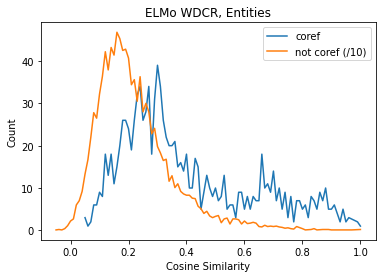

In [124]:
import matplotlib.pyplot as plt

wd_x_coref = [x[0] for x in sorted(wd_result.items())] 
wd_y_coref = [x[1] for x in sorted(wd_result.items())]
wd_x_notc = [x[0] for x in sorted(wd_notc_result.items())]
wd_y_notc = [x[1]/10 for x in sorted(wd_notc_result.items())]

# plot lines
plt.plot(wd_x_coref, wd_y_coref, label = "coref")
plt.plot(wd_x_notc, wd_y_notc, label = "not coref (/10)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.title("ELMo WDCR, Entities")
plt.plot()
plt.legend()
plt.savefig("ELMo_wd_Entities.jpeg", dpi=800)
plt.show()


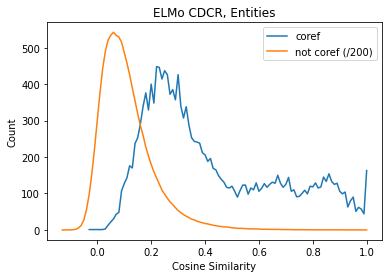

In [125]:
cd_x_coref = [x[0] for x in sorted(cd_result.items())] 
cd_y_coref = [x[1] for x in sorted(cd_result.items())]
cd_x_notc = [x[0] for x in sorted(cd_notc_result.items())]
cd_y_notc = [x[1]/200 for x in sorted(cd_notc_result.items())]

import matplotlib.pyplot as plt
  
# plot lines
plt.plot(cd_x_coref, cd_y_coref, label = "coref")
plt.plot(cd_x_notc, cd_y_notc, label = "not coref (/200)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.title("ELMo CDCR, Entities")
plt.plot()
plt.legend()
plt.savefig("ELMo_cd_Entities.jpeg", dpi=800)
plt.show()


## Testing the structure

In [50]:
topics = training_data.topics

In [16]:
topics

{'1_ecb': <classes.Topic at 0x7f4ecb40c860>,
 '3_ecb': <classes.Topic at 0x7f4ecac0ce80>,
 '4_ecb': <classes.Topic at 0x7f4ecaa32c18>,
 '6_ecb': <classes.Topic at 0x7f4eca5fec50>,
 '7_ecb': <classes.Topic at 0x7f4eca46f7f0>,
 '8_ecb': <classes.Topic at 0x7f4eca1ecfd0>,
 '9_ecb': <classes.Topic at 0x7f4ec9f4f780>,
 '10_ecb': <classes.Topic at 0x7f4ec9be5a90>,
 '11_ecb': <classes.Topic at 0x7f4ec99f8160>,
 '13_ecb': <classes.Topic at 0x7f4ec9771780>,
 '14_ecb': <classes.Topic at 0x7f4ec928ac50>,
 '16_ecb': <classes.Topic at 0x7f4ec90ea240>,
 '19_ecb': <classes.Topic at 0x7f4ec9034cf8>,
 '20_ecb': <classes.Topic at 0x7f4ec8c0ecf8>,
 '22_ecb': <classes.Topic at 0x7f4ec8ab77b8>,
 '24_ecb': <classes.Topic at 0x7f4ec87bda90>,
 '25_ecb': <classes.Topic at 0x7f4ec84aba90>,
 '26_ecb': <classes.Topic at 0x7f4ec7f36278>,
 '27_ecb': <classes.Topic at 0x7f4ec78ac5f8>,
 '28_ecb': <classes.Topic at 0x7f4ec6f5f5f8>,
 '29_ecb': <classes.Topic at 0x7f4ec68f4898>,
 '30_ecb': <classes.Topic at 0x7f4ec63cf1

In [19]:
all_docs = []
for i,topic in topics.items():
        all_docs.append(topic.docs)
all_docs[0]

{'1_10ecb': <classes.Document at 0x7f4ecb40cd30>,
 '1_11ecb': <classes.Document at 0x7f4ecb38c518>,
 '1_12ecb': <classes.Document at 0x7f4ecb372400>,
 '1_13ecb': <classes.Document at 0x7f4ecb310358>,
 '1_14ecb': <classes.Document at 0x7f4ecb3ffe80>,
 '1_15ecb': <classes.Document at 0x7f4ecb211a20>,
 '1_17ecb': <classes.Document at 0x7f4ecb1f9c50>,
 '1_18ecb': <classes.Document at 0x7f4ecb0fddd8>,
 '1_19ecb': <classes.Document at 0x7f4ecb07e2e8>,
 '1_1ecb': <classes.Document at 0x7f4ecb05d7f0>,
 '1_2ecb': <classes.Document at 0x7f4ecafea940>,
 '1_3ecb': <classes.Document at 0x7f4ecaf6b080>,
 '1_4ecb': <classes.Document at 0x7f4ecaf7b828>,
 '1_5ecb': <classes.Document at 0x7f4ecaee09e8>,
 '1_6ecb': <classes.Document at 0x7f4ecae70a58>,
 '1_7ecb': <classes.Document at 0x7f4ecada0128>,
 '1_8ecb': <classes.Document at 0x7f4ecacec9b0>,
 '1_9ecb': <classes.Document at 0x7f4ecac489e8>}

In [100]:
sentences = []
for i,doc in all_docs[0].items():
        sentences.append(doc.sentences)
sentences

[{0: <classes.Sentence at 0x7f4ecb40cda0>,
  3: <classes.Sentence at 0x7f4ecb3c32e8>},
 {0: <classes.Sentence at 0x7f4ecb38c550>,
  2: <classes.Sentence at 0x7f4ecb39dda0>},
 {1: <classes.Sentence at 0x7f4ecb372438>},
 {1: <classes.Sentence at 0x7f4ecb310390>},
 {0: <classes.Sentence at 0x7f4ecb3ffa90>,
  1: <classes.Sentence at 0x7f4ecb2ee1d0>,
  2: <classes.Sentence at 0x7f4ecb2fac18>,
  5: <classes.Sentence at 0x7f4ecb266a20>},
 {0: <classes.Sentence at 0x7f4ecb211a58>,
  1: <classes.Sentence at 0x7f4ecb23ae48>},
 {0: <classes.Sentence at 0x7f4ecb1f9c88>,
  1: <classes.Sentence at 0x7f4ecb144438>,
  2: <classes.Sentence at 0x7f4ecb144dd8>},
 {0: <classes.Sentence at 0x7f4ecb0fde10>},
 {0: <classes.Sentence at 0x7f4ecb07e320>,
  1: <classes.Sentence at 0x7f4ecb07ec88>,
  3: <classes.Sentence at 0x7f4ecb03e3c8>},
 {1: <classes.Sentence at 0x7f4ecb05d828>,
  2: <classes.Sentence at 0x7f4ecafc75c0>},
 {0: <classes.Sentence at 0x7f4ecafea978>,
  2: <classes.Sentence at 0x7f4ecaf92a58>},


In [101]:
event_mentions = []
entity_mentions = []
for i,sent in sentences[0].items():
    if i == 0:
        entity_mentions.append(sent.gold_entity_mentions)
        event_mentions.append(sent.gold_event_mentions)
        


In [102]:
event_mentions

[[<classes.EventMention at 0x7f4ecb41e6d8>,

In [103]:
entity_mentions

[[<classes.EntityMention at 0x7f4ecb41ea20>,

In [106]:
entity_mentions[0][0].get_tokens()

['Tara', 'Reid']

In [107]:
event_mentions[0][0].gold_tag

'ACT16236402809085484'